In [91]:
import os
from PIL import Image
import numpy as np
import cv2
from tqdm import tqdm

DATA_DIR = r"D:\IV2 dataset\vehicle_dataset"
SAFE_DIR = r"D:\IV2 dataset\vehicle_dataset_clean"
os.makedirs(SAFE_DIR, exist_ok=True)

# Thresholds
BLUR_THRESHOLD = 100
DARK_THRESHOLD = 50
LIGHT_THRESHOLD = 200
MIN_WIDTH = 50
MIN_HEIGHT = 50
ODD_ASPECT_RATIO = (0.5, 2.0)

def is_image_file(filename):
    return filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp'))

def is_blurry(image):
    gray = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2GRAY)
    fm = cv2.Laplacian(gray, cv2.CV_64F).var()
    return fm < BLUR_THRESHOLD

def is_dark(image):
    gray = np.array(image.convert('L'))
    return gray.mean() < DARK_THRESHOLD

def is_light(image):
    gray = np.array(image.convert('L'))
    return gray.mean() > LIGHT_THRESHOLD

def is_small_or_odd(image):
    w, h = image.size
    ratio = w / h
    return w < MIN_WIDTH or h < MIN_HEIGHT or not (ODD_ASPECT_RATIO[0] <= ratio <= ODD_ASPECT_RATIO[1])

clean_count = 0
removed_count = 0

# Recursively loop through all images in DATA_DIR and subfolders
for root, dirs, files in os.walk(DATA_DIR):
    for file in tqdm(files):
        if not is_image_file(file):
            continue
        try:
            path = os.path.join(root, file)
            img = Image.open(path).convert('RGB')

            if is_blurry(img) or is_dark(img) or is_light(img) or is_small_or_odd(img):
                removed_count += 1
                continue

            # save clean images preserving folder structure
            rel_path = os.path.relpath(root, DATA_DIR)
            save_dir = os.path.join(SAFE_DIR, rel_path)
            os.makedirs(save_dir, exist_ok=True)
            img.save(os.path.join(save_dir, file))
            clean_count += 1
        except Exception as e:
            print(f"Skipping {file}: {e}")
            removed_count += 1

print(f"Clean images saved: {clean_count}")
print(f"Removed/Skipped images: {removed_count}")


0it [00:00, ?it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████| 351/351 [00:01<00:00, 282.64it/s]
0it [00:00, ?it/s]
100%|█████████████████████████████████████████████████████████████████████| 103/103 [00:00<00:00, 242.15it/s]

Clean images saved: 2854
Removed/Skipped images: 630


In [92]:
import os
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, WeightedRandomSampler
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix


In [93]:

print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))
else:
    print("CUDA not available")


CUDA available: True
GPU Name: NVIDIA GeForce RTX 3050 Laptop GPU


In [94]:
DATA_DIR = r"D:\IV2 dataset\vehicle_dataset"
TRAIN_DIR = os.path.join(DATA_DIR, "train")
VAL_DIR = os.path.join(DATA_DIR, "val")


<Axes: xlabel='class'>

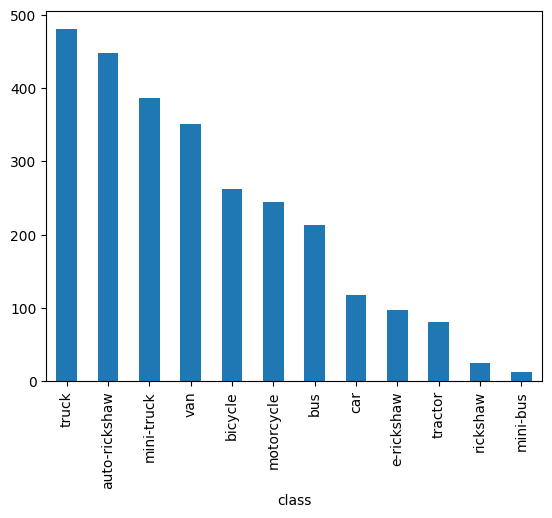

In [95]:
from collections import Counter
import pandas as pd

train_data = datasets.ImageFolder(TRAIN_DIR)
val_data = datasets.ImageFolder(VAL_DIR)

df = pd.DataFrame(train_data.samples, columns=["path","label"])
df["class"] = df["label"].apply(lambda x: train_data.classes[x])
df["class"].value_counts().plot(kind="bar")


In [96]:
IMG_SIZE = 224
train_transforms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


In [97]:
train_ds = datasets.ImageFolder(TRAIN_DIR, transform=train_transforms)
val_ds = datasets.ImageFolder(VAL_DIR, transform=val_transforms)

# handle imbalance
class_counts = Counter([s[1] for s in train_ds.samples])
weights = [1/class_counts[s[1]] for s in train_ds.samples]
sampler = WeightedRandomSampler(weights, len(weights), replacement=True)

train_loader = DataLoader(train_ds, batch_size=32, sampler=sampler)
val_loader = DataLoader(val_ds, batch_size=32, shuffle=False)

num_classes = len(train_ds.classes)
print(train_ds.classes)


['auto-rickshaw', 'bicycle', 'bus', 'car', 'e-rickshaw', 'mini-bus', 'mini-truck', 'motorcycle', 'rickshaw', 'tractor', 'truck', 'van']


In [98]:
with open("classes.txt","w") as f:
    for c in train_ds.classes:
        f.write(c+"\n")


In [99]:
from torchvision.models import efficientnet_b3, EfficientNet_B3_Weights
weights = EfficientNet_B3_Weights.DEFAULT
model = efficientnet_b3(weights=weights)
in_feats = model.classifier[1].in_features
model.classifier[1] = nn.Sequential(
    nn.Dropout(0.3),  # 30% dropout
    nn.Linear(in_feats, num_classes)
)
model = model.to("cuda")


Downloading: "https://download.pytorch.org/models/efficientnet_b3_rwightman-b3899882.pth" to C:\Users\asus/.cache\torch\hub\checkpoints\efficientnet_b3_rwightman-b3899882.pth
100.0%


In [100]:
criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

def train_one_epoch():
    model.train()
    total, correct, loss_sum = 0, 0, 0
    for imgs, labels in train_loader:
        imgs, labels = imgs.cuda(), labels.cuda()
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()*imgs.size(0)
        correct += (out.argmax(1)==labels).sum().item()
        total += labels.size(0)
    return loss_sum/total, correct/total

def validate():
    model.eval()
    y_true, y_pred = [], []
    loss_sum, total = 0,0
    with torch.no_grad():
        for imgs, labels in val_loader:
            imgs, labels = imgs.cuda(), labels.cuda()
            out = model(imgs)
            loss = criterion(out, labels)
            loss_sum += loss.item()*imgs.size(0)
            total += labels.size(0)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(out.argmax(1).cpu().numpy())
    acc = np.mean(np.array(y_true)==np.array(y_pred))
    return loss_sum/total, acc, y_true, y_pred


In [109]:
best_acc = 0
history = {"train_acc":[],"val_acc":[]}
epochs_no_improve = 0
# patience = 5  # stop if val acc does not improve for 5 epochs
max_epochs = 25

for epoch in range(max_epochs):
    tloss, tacc = train_one_epoch()
    vloss, vacc, y_true, y_pred = validate()
    
    history["train_acc"].append(tacc)
    history["val_acc"].append(vacc)
    
    print(f"Epoch {epoch+1}: Train {tacc:.3f}, Val {vacc:.3f}")
    


Epoch 1: Train 0.963, Val 0.843
Epoch 2: Train 0.968, Val 0.859
Epoch 3: Train 0.960, Val 0.881
Epoch 4: Train 0.969, Val 0.873
Epoch 5: Train 0.971, Val 0.850
Epoch 6: Train 0.970, Val 0.846
Epoch 7: Train 0.968, Val 0.865
Epoch 8: Train 0.975, Val 0.865
Epoch 9: Train 0.979, Val 0.882
Epoch 10: Train 0.978, Val 0.863
Epoch 11: Train 0.975, Val 0.848
Epoch 12: Train 0.976, Val 0.848
Epoch 13: Train 0.975, Val 0.888
Epoch 14: Train 0.982, Val 0.884
Epoch 15: Train 0.978, Val 0.873
Epoch 16: Train 0.975, Val 0.829
Epoch 17: Train 0.973, Val 0.859
Epoch 18: Train 0.984, Val 0.869
Epoch 19: Train 0.983, Val 0.863
Epoch 20: Train 0.982, Val 0.848
Epoch 21: Train 0.985, Val 0.876
Epoch 22: Train 0.976, Val 0.846
Epoch 23: Train 0.987, Val 0.861
Epoch 24: Train 0.987, Val 0.869
Epoch 25: Train 0.986, Val 0.856


               precision    recall  f1-score   support

auto-rickshaw       0.92      0.79      0.85       137
      bicycle       1.00      0.87      0.93        69
          bus       0.69      0.86      0.77        71
          car       0.69      0.83      0.75        35
   e-rickshaw       0.60      1.00      0.75         6
     mini-bus       1.00      1.00      1.00         1
   mini-truck       0.80      0.93      0.86       102
   motorcycle       0.88      0.99      0.93        69
     rickshaw       0.92      0.92      0.92        12
      tractor       0.60      1.00      0.75         3
        truck       0.87      0.74      0.80       157
          van       0.96      0.94      0.95       103

     accuracy                           0.86       765
    macro avg       0.83      0.90      0.86       765
 weighted avg       0.87      0.86      0.86       765



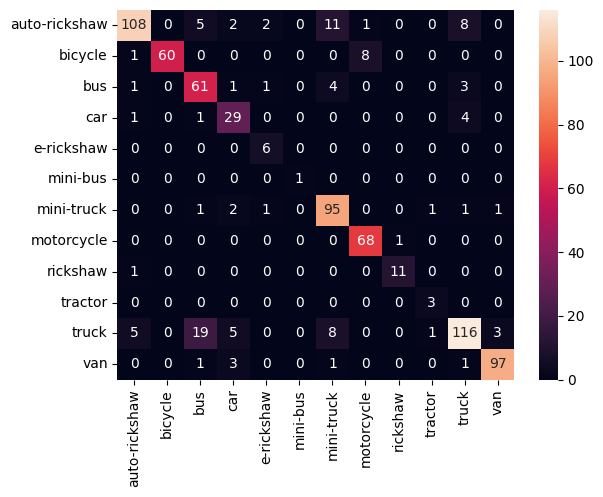

In [110]:
print(classification_report(y_true,y_pred,target_names=train_ds.classes))
cm = confusion_matrix(y_true,y_pred)
sns.heatmap(cm,annot=True,fmt="d",xticklabels=train_ds.classes,yticklabels=train_ds.classes)
plt.show()


In [111]:
import onnx
dummy = torch.randn(1,3,180,180).cuda()
state_dict = torch.load("best_val_loss.pt", weights_only=True)
model.load_state_dict(state_dict)
model.eval()
torch.onnx.export(model, dummy, "vehicle_test.onnx", input_names=['input'], output_names=['output'], opset_version=13)


In [112]:
from sklearn.metrics import average_precision_score
import torch.nn.functional as F

model.eval()
y_true, y_scores = [], []
with torch.no_grad():
    for imgs, labels in val_loader:
        imgs, labels = imgs.cuda(), labels.cuda()
        out = model(imgs)
        probs = F.softmax(out, dim=1).cpu().numpy()
        y_scores.extend(probs)
        y_true.extend(labels.cpu().numpy())

y_true_bin = np.eye(num_classes)[y_true]  # one-hot
y_scores = np.array(y_scores)

aps = []
for i in range(num_classes):
    ap = average_precision_score(y_true_bin[:, i], y_scores[:, i])
    aps.append(ap)
print("Per-class AP:", aps)
print("mAP:", np.mean(aps))


Per-class AP: [0.9487926887227376, 0.9969728562898835, 0.8663451040330813, 0.8178274250214372, 0.7166666666666667, 0.5, 0.9523117825818666, 0.978349138385935, 0.8066710637302631, 1.0, 0.881937788005632, 0.9880596681892034]
mAP: 0.8711611818022257


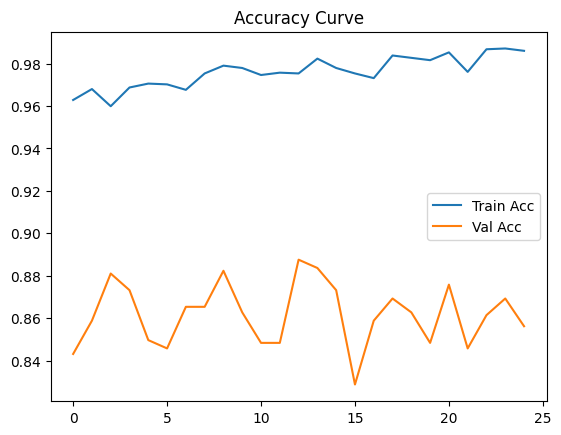

In [113]:
plt.plot(history['train_acc'], label='Train Acc')
plt.plot(history['val_acc'], label='Val Acc')
plt.legend(); plt.title("Accuracy Curve")
plt.show()


In [114]:
model_resnet = models.resnet18(weights="IMAGENET1K_V1")
in_feats = model_resnet.fc.in_features
model_resnet.fc = nn.Linear(in_feats, num_classes)


In [115]:
%run verify_model.py -m vehicle_test.onnx -c classes.txt -s 180


input shape [1, 3, 180, 180]
output shape [1, 12]

bus
 2.27
Image prediction successfully saved to ./runs/pred\pred_autorickshaw.png
car
 3.44
Image prediction successfully saved to ./runs/pred\pred_car.png
truck
 1.68
Image prediction successfully saved to ./runs/pred\pred_van.png


In [116]:
# Final validation accuracy
_, final_acc, _, _ = validate()
print(f"Final Validation Accuracy: {final_acc*100:.2f}%")
print(f"Best Validation Accuracy: {best_acc*100:.2f}%")
print(f"Last Epoch Train Accuracy: {history['train_acc'][-1]*100:.2f}%")
print(f"Last Epoch Val Accuracy: {history['val_acc'][-1]*100:.2f}%")


Final Validation Accuracy: 88.24%
Best Validation Accuracy: 0.00%
Last Epoch Train Accuracy: 98.60%
Last Epoch Val Accuracy: 85.62%
